In [2]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [5]:
DATA_STORE = '/Users/Massimiliano/assets.h5'

In [6]:
START = 2000
END = 2018

In [7]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    stocks = store['us_equities/stocks'].loc[:, ['Market Cap', 'IPO Year', 'Sector']]

In [8]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


In [9]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4314 entries, AACG to ZYXI
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Market Cap  4302 non-null   float64
 1   IPO Year    2622 non-null   float64
 2   Sector      4184 non-null   object 
dtypes: float64(2), object(1)
memory usage: 134.8+ KB


In [10]:
#Remove stocks duplicates and align index names for later joining.
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

#Get tickers with both price information and metadata
shared = prices.columns.intersection(stocks.index)
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 843 entries, AAL to ZUMZ
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Market Cap  843 non-null    float64
 1   IPO Year    447 non-null    float64
 2   Sector      836 non-null    object 
dtypes: float64(2), object(1)
memory usage: 26.3+ KB


In [11]:
#resamplemonthlyreturns
monthly_prices = prices.resample('M').last()

In [12]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: M
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 5.3 MB


In [13]:
#To capture time series dynamics that reflect, for example, momentum patterns, 
#we compute historical returns using the method .pct_change(n_periods), 
#that is, returns over various monthly periods as identified by lags.

#We then convert the wide result back to long format with the .stack() method, 
#use .pipe() to apply the .clip() method to the resulting DataFrame, and 
#Finally, we normalize returns using the geometric average. 
#winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.
#After using .swaplevel() to change the order of the MultiIndex levels, 
#we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [14]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 521806 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   521806 non-null  float64
 1   return_2m   521806 non-null  float64
 2   return_3m   521806 non-null  float64
 3   return_6m   521806 non-null  float64
 4   return_9m   521806 non-null  float64
 5   return_12m  521806 non-null  float64
dtypes: float64(6)
memory usage: 26.0+ MB


In [15]:
#Drop stocks with less than 10 yrs of returns

In [16]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   465935 non-null  float64
 1   return_2m   465935 non-null  float64
 2   return_3m   465935 non-null  float64
 3   return_6m   465935 non-null  float64
 4   return_9m   465935 non-null  float64
 5   return_12m  465935 non-null  float64
dtypes: float64(6)
memory usage: 23.3+ MB


In [17]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,465935.000000,465935.000000,465935.000000,465935.000000,465935.000000,465935.000000
mean,0.011694,0.008454,0.007306,0.006036,0.005542,0.005285
std,0.117872,0.084059,0.069195,0.050674,0.041919,0.036635
min,-0.343442,-0.269341,-0.229978,-0.175426,-0.145071,-0.125787
25%,-0.046679,-0.031096,-0.024413,-0.015632,-0.012035,-0.009962
50%,0.006369,0.007476,0.007810,0.008024,0.007924,0.007852
75%,0.065314,0.048890,0.041722,0.031742,0.027062,0.024439
max,0.449446,0.294075,0.230064,0.159207,0.128147,0.108809


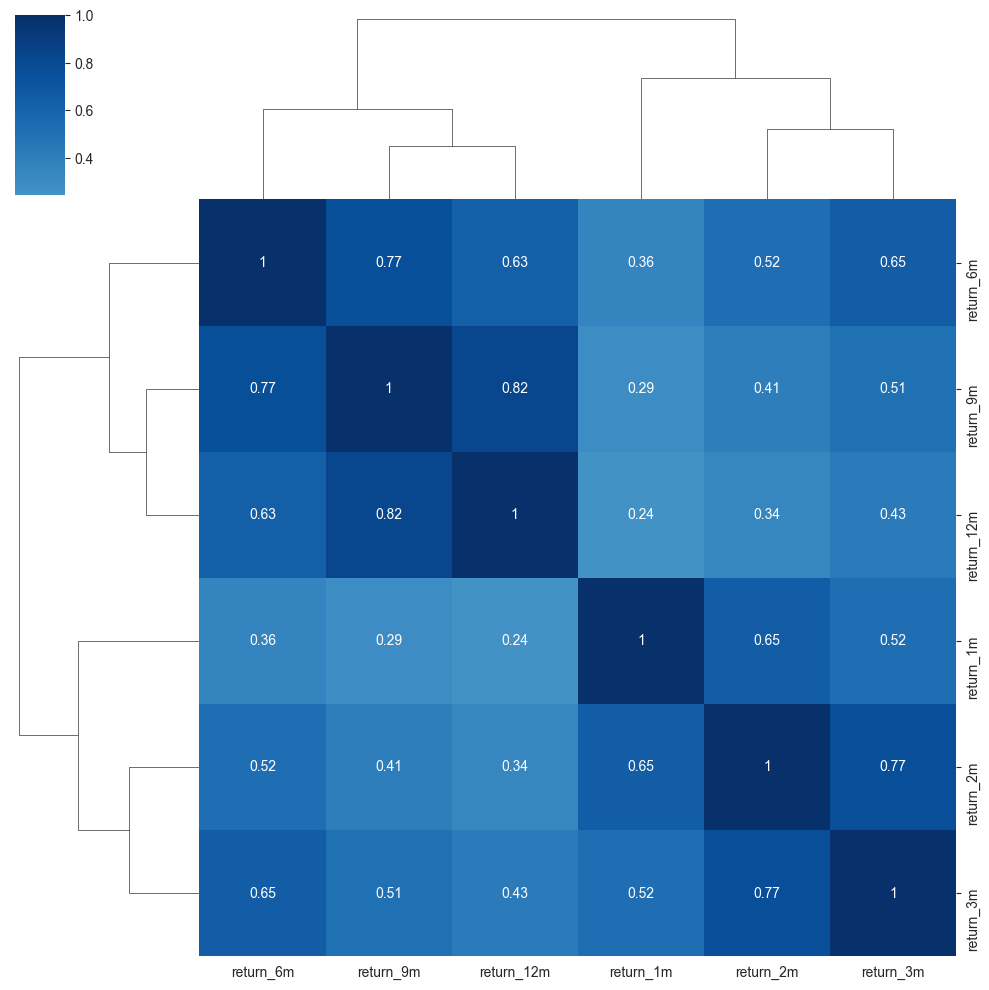

In [18]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

In [19]:
#n of tickers left
data.index.get_level_values('ticker').nunique()

2385

In [20]:
#the five Fama—French factors, namely market risk, size, value, operating profitability,
# and investment have been shown empirically to explain asset returns and are commonly used 
# to assess the risk/return profile of portfolios. Hence, it is natural to include past 
# factor exposures as financial features in models that aim to predict future returns.We can access 
# the historical factor returns using the pandas-datareader and estimate historical exposures 
# using the RollingOLS rolling linear regression functionality in the statsmodels library as follows:
# Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to 
# the 5 factors market risk, size, value, operating profitability and investment.

In [21]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 283 entries, 2000-01-31 to 2023-07-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  283 non-null    float64
 1   SMB     283 non-null    float64
 2   HML     283 non-null    float64
 3   RMW     283 non-null    float64
 4   CMA     283 non-null    float64
dtypes: float64(5)
memory usage: 13.3 KB


In [22]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     465935 non-null  float64
 1   SMB        465935 non-null  float64
 2   HML        465935 non-null  float64
 3   RMW        465935 non-null  float64
 4   CMA        465935 non-null  float64
 5   return_1m  465935 non-null  float64
dtypes: float64(6)
memory usage: 23.3+ MB


In [23]:
T = 24
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [24]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,411080.000000,411080.000000,411080.000000,4.110800e+05,411080.000000,465935.000000
mean,0.973492,0.636987,0.114794,-9.588593e-02,0.011020,1.447280
std,0.950564,1.299703,1.665761,1.970651e+00,2.250540,3.417199
min,-9.839232,-10.501530,-15.440012,-2.388501e+01,-20.177240,-34.475140
25%,0.429052,-0.118705,-0.727252,-1.038744e+00,-1.110432,0.000000
50%,0.918570,0.541603,0.073721,2.795177e-15,0.017130,1.123828
75%,1.458601,1.331325,0.948263,9.435047e-01,1.153548,3.149559
max,10.965766,10.437477,16.273464,1.894054e+01,21.483337,39.249219


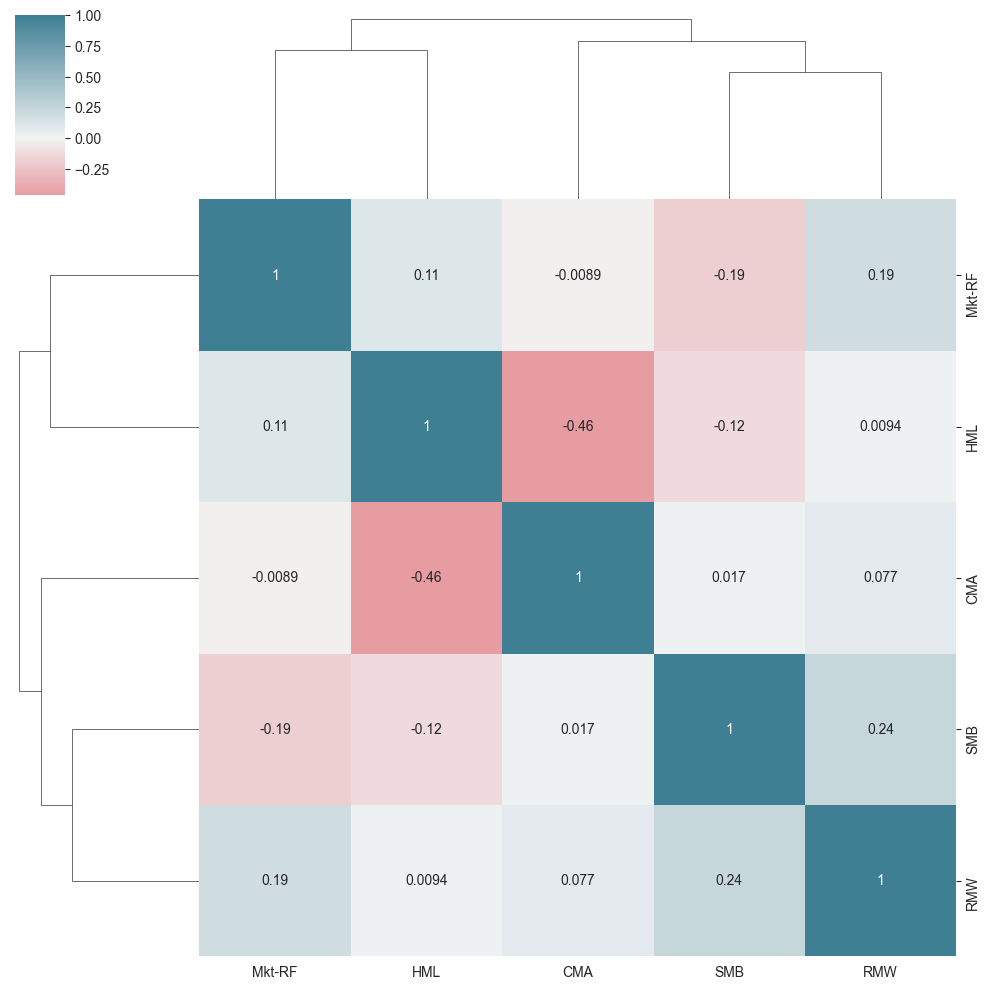

In [25]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0)

In [26]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   465935 non-null  float64
 1   return_2m   465935 non-null  float64
 2   return_3m   465935 non-null  float64
 3   return_6m   465935 non-null  float64
 4   return_9m   465935 non-null  float64
 5   return_12m  465935 non-null  float64
 6   Mkt-RF      408695 non-null  float64
 7   SMB         408695 non-null  float64
 8   HML         408695 non-null  float64
 9   RMW         408695 non-null  float64
 10  CMA         408695 non-null  float64
dtypes: float64(11)
memory usage: 57.2+ MB


In [27]:
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   465935 non-null  float64
 1   return_2m   465935 non-null  float64
 2   return_3m   465935 non-null  float64
 3   return_6m   465935 non-null  float64
 4   return_9m   465935 non-null  float64
 5   return_12m  465935 non-null  float64
 6   Mkt-RF      465935 non-null  float64
 7   SMB         465935 non-null  float64
 8   HML         465935 non-null  float64
 9   RMW         465935 non-null  float64
 10  CMA         465935 non-null  float64
dtypes: float64(11)
memory usage: 57.2+ MB


In [28]:
#We can use these results to compute momentum factors based on the difference between 
# returns over longer periods and the most recent monthly return, as well as for 
# the difference between 3 and 12 month returns as follows:

In [29]:
for lag in [2,3,6,9,12]:
data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

In [30]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

In [ ]:
#To use lagged values as input variables or features associated with the current observations,
#  we use the .shift() method to move historical returns up to the current period:

In [31]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      465935 non-null  float64
 1   return_2m      465935 non-null  float64
 2   return_3m      465935 non-null  float64
 3   return_6m      465935 non-null  float64
 4   return_9m      465935 non-null  float64
 5   return_12m     465935 non-null  float64
 6   Mkt-RF         465935 non-null  float64
 7   SMB            465935 non-null  float64
 8   HML            465935 non-null  float64
 9   RMW            465935 non-null  float64
 10  CMA            465935 non-null  float64
 11  momentum_2     465935 non-null  float64
 12  momentum_3     465935 non-null  float64
 13  momentum_6     465935 non-null  float64
 14  momentum_9     465935 non-null  float64
 15  momentum_12    465935 non

In [32]:
#Similarly, to compute returns for various holding periods, we use the normalized period returns 
# computed previously and shift them back to align them with the current financial features

In [33]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [34]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.340055      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.340055  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130